## **The primary goal of this machine learning model is to enhance the integrity and quality assurance of a digital web health platform repository by implementing text classification. Specifically, the model is designed to identify and categorize health-related article links. By leveraging machine learning techniques, the platform aims to streamline the detection process, ensuring that the repository maintains a high standard of health-related content. This proactive approach not only enhances the overall quality of the platform but also contributes to a more robust and reliable user experience.**


The dataset used for training this machine learning model involved a manual labeling process to categorize Text as either health-related (labeled as '1') or non-health-related (labeled as '0'). The dataset consists of two columns: 'Label' and 'Text.' The 'Label' column denoted whether the corresponding Text is health-related (1) or not (0). This manual labeling process provided the necessary ground truth for the model to learn and generalize patterns, enabling it to accurately classify health-related article links on a digital web health platform repository through text classification. The text data was taken from [link text](https://github.com/mhjabreel/CharCnn_Keras/blob/master/data/ag_news_csv/) while the medical text data was taken from MetaText





**Importing** **the** **required** **Libraries**





In [52]:
import os
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##**DATAPREPARATION**


In [53]:
#Load dataset from the drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
# Load the traind.csv file

df = pd.read_csv('/content/drive/MyDrive/datasets/traind.csv')




In [55]:
# Use this method to remove data to avoid overfitting of the model. The data was leaning closely to (0) and so removing some rows enabled a balanced set

start_row = 30000

# Delete rows from the specified row number onwards
df = df.iloc[:start_row]

# Save the modified DataFrame to a new CSV file
df.to_csv('new_file.csv', index=False)


##**VISUALIZE DATAFRAME**

In [56]:
# Read trainD data
df.head()

,Label,Text
0,1.0,Catheterization laboratory events and hospital...
1,1.0,Renal abscess in children. Three cases of rena...
2,1.0,Hyperplastic polyps seen at sigmoidoscopy are ...
3,1.0,Subclavian artery to innominate vein fistula a...
4,1.0,Effect of local inhibition of gamma-aminobutyr...


In [57]:
df.tail()

,Label,Text
29995,0.0,"AP - Consumer confidence, which had been on th..."
29996,0.0,LONDON (Reuters) - British junior foreign off...
29997,0.0,Ziff Davis - Longhorn's woes may open a door f...
29998,0.0,"Reuters - Veritas Software Corp. , the\leading..."
29999,0.0,"Reuters - Albertsons Inc. , the No. 2\U.S. gro..."


In [58]:
print(df['Label'].value_counts())


0.0    15562
1.0    14438
Name: Label, dtype: int64


##**DATAPREPROCESSING**






**TextCleaning**:



**Here** we perform text cleaning steps
For each sentence, we apply the following transformations:
 1. Lowercase words
 2. Remove standalone numbers
 3. Tokenize and remove stopwords
 4. Lemmatize words
 5. Remove punctuation and special characters
 6. Compute the sentiment score for each sentence


In [59]:
import pandas as pd
import spacy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Load spaCy model
nlp = spacy.load('en_core_web_sm')


# nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Defining a function for text preprocessing
def preprocess_text(text):
    # Tokenize text into sentences
    sents = nltk.sent_tokenize(text)

    processed_texts = []
    sentiment_scores = []

    for sent in sents:
        # Tokenize sentence into words
        words = nltk.word_tokenize(sent)

        # Lowercase words, remove standalone numbers
        words = [word.lower() for word in words if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Remove punctuation and special characters
        words = re.sub(r'[^\w\s]', '', ' '.join(words)).split()

        # Compute sentiment score for each sentence
        sentiment_score = sia.polarity_scores(sent)
        sentiment_scores.append(sentiment_score)
        processed_texts.extend(words)  # Extend instead of appending

    return processed_texts, sentiment_scores

# Apply the preprocessing function to the 'Text' column of the DataFrame
df['Processed_Text'], df['Sentiment_Scores'] = zip(*df['Text'].apply(preprocess_text).tolist())

print(df.head(10))
df.tail()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   Label                                               Text  \
0    1.0  Catheterization laboratory events and hospital...   
1    1.0  Renal abscess in children. Three cases of rena...   
2    1.0  Hyperplastic polyps seen at sigmoidoscopy are ...   
3    1.0  Subclavian artery to innominate vein fistula a...   
4    1.0  Effect of local inhibition of gamma-aminobutyr...   
5    1.0  Infection during chronic epidural catheterizat...   
6    1.0  Mediastinal tracheostomy using a pectoralis ma...   
7    1.0  Tumefactive fibroinflammatory lesion of the ex...   
8    1.0  Multiple representations contribute to body kn...   
9    1.0  Increasing asthma prevalence in a rural New Ze...   

                                      Processed_Text  \
0  [catheterization, laboratory, event, hospital,...   
1  [renal, abscess, child, three, case, renal, ab...   
2  [hyperplastic, polyp, seen, sigmoidoscopy, mar...   
3  [subclavian, artery, innominate, vein, fistula...   
4  [effect, local, inhibit

,Label,Text,Processed_Text,Sentiment_Scores
29995,0.0,"AP - Consumer confidence, which had been on th...","[ap, consumer, confidence, rise, since, april,...","[{'neg': 0.0, 'neu': 0.858, 'pos': 0.142, 'com..."
29996,0.0,LONDON (Reuters) - British junior foreign off...,"[london, reuters, british, junior, foreign, of...","[{'neg': 0.069, 'neu': 0.931, 'pos': 0.0, 'com..."
29997,0.0,Ziff Davis - Longhorn's woes may open a door f...,"[ziff, davis, longhorn, woe, may, open, door, ...","[{'neg': 0.218, 'neu': 0.782, 'pos': 0.0, 'com..."
29998,0.0,"Reuters - Veritas Software Corp. , the\leading...","[reuters, veritas, software, storage, software...","[{'neg': 0.0, 'neu': 0.916, 'pos': 0.084, 'com..."
29999,0.0,"Reuters - Albertsons Inc. , the No. 2\U.S. gro...","[reuters, albertsons, grocer, tuesday, reporte...","[{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'com..."


##**TRAINING** **AND** **EVALUATION** **OF** **THE** **MODEL**


Here, we train our model to learn the features of health-related and non-health-related text. During the training process, the model analyzes the provided dataset, understanding the distinctive characteristics that distinguish between text related to health and other non-health topics. By capturing these features, the model gains the capability to make informed predictions and classify *text* accurately.

**RANDOMFORESTCLASSIFIER**

For this health-related Text classification, a Random Forest Classifier is chosen for its robustness to noise, ability to identify key features in text, and effective handling of non-linear patterns in language.

Confusion Matrix:
[[3069    8]
 [   4 2919]]


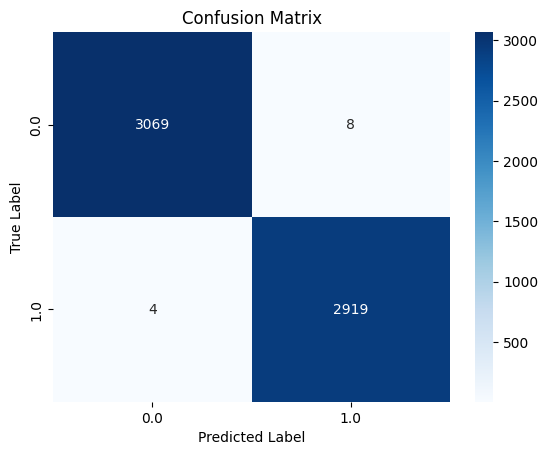

TEST ACCURACY: 0.998

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3077
         1.0       1.00      1.00      1.00      2923

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [60]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Splitting data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Processed_Text'], df['Label'], test_size=0.2, random_state=42)

# Convert list of lists into list of strings
train_texts = [' '.join(text) for text in train_texts]
test_texts = [' '.join(text) for text in test_texts]

model_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Training the model
model_rf.fit(train_texts, train_labels)

# Make predictions on the test set
predictions = model_rf.predict(test_texts)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Evaluate performance
accuracy = accuracy_score(test_labels, predictions)
print(f'TEST ACCURACY: {accuracy}\n')

# Print classification report
print(classification_report(test_labels, predictions))




**LOGISTC REGRESSION**


For health-related text classification, Logistic Regression is selected for its simplicity, interpretability, and effectiveness in modeling linear relationships between text features and the target variable.








Confusion Matrix:
[[3072    5]
 [   8 2915]]


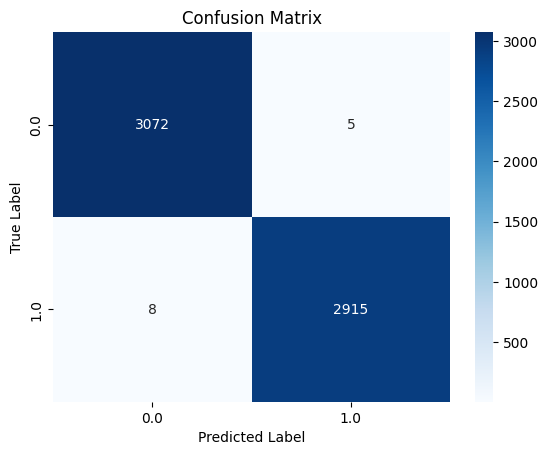

TEST ACCURACY: 0.9978333333333333

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3077
         1.0       1.00      1.00      1.00      2923

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Processed_Text'], df['Label'], test_size=0.2, random_state=42)

# Converting list of lists into list of strings
train_texts = [' '.join(text) for text in train_texts]
test_texts = [' '.join(text) for text in test_texts]

model_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model
model_lr.fit(train_texts, train_labels)

# Make predictions on the test set
predictions = model_lr.predict(test_texts)


# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Evaluate performance
accuracy = accuracy_score(test_labels, predictions)
print(f'TEST ACCURACY: {accuracy}\n')

# classification report
print(classification_report(test_labels, predictions))




**Support Vector Classifier**

Support Vector Classifier (SVC) is employed for health-related Text classification due to its capability to handle high-dimensional text data, effective non-linear mapping through kernel functions, and potential for capturing complex relationships in the dataset.



Confusion Matrix:
[[3076    1]
 [   5 2918]]


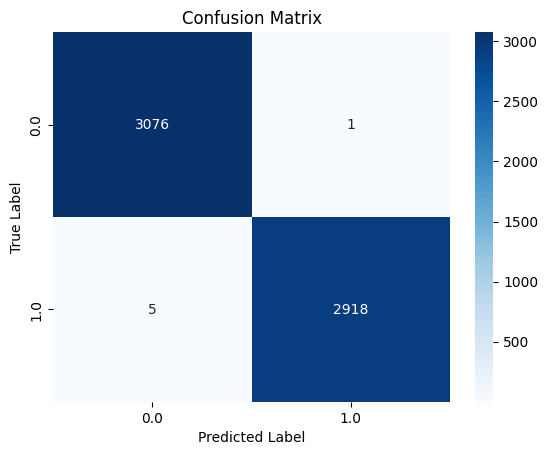

TEST ACCURACY: 0.999

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3077
         1.0       1.00      1.00      1.00      2923

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Processed_Text'], df['Label'], test_size=0.2, random_state=42)

# Convert list of lists into list of strings
train_texts = [' '.join(text) for text in train_texts]
test_texts = [' '.join(text) for text in test_texts]

# Create a pipeline with TF-IDF vectorizer and Support Vector Machine classifier
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC(kernel='linear'))
])

# Train the model
model.fit(train_texts, train_labels)

# Make predictions on the test set
predictions = model.predict(test_texts)


# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Evaluate performance
accuracy = accuracy_score(test_labels, predictions)
print(f'TEST ACCURACY: {accuracy}\n')

# Print classification report
print(classification_report(test_labels, predictions))





**XGBClassifier**

Confusion Matrix:
[[3069    8]
 [  15 2908]]


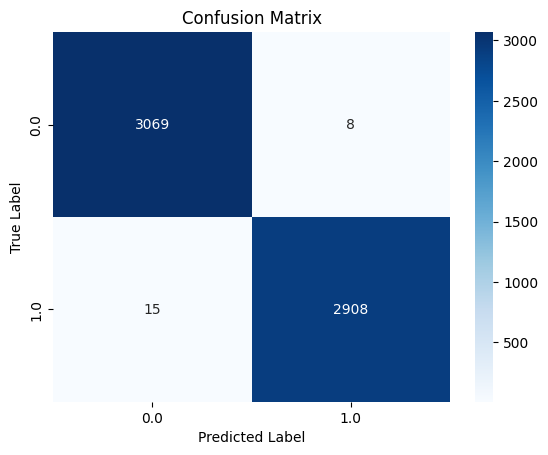

TEST ACCURACY: 0.9961666666666666

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3077
         1.0       1.00      0.99      1.00      2923

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [63]:
from xgboost import XGBClassifier


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Split data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Processed_Text'], df['Label'], test_size=0.2, random_state=42)

# Convert list of lists into list of strings
train_texts = [' '.join(text) for text in train_texts]
test_texts = [' '.join(text) for text in test_texts]

# Create a pipeline with TF-IDF vectorizer and Support Vector Machine classifier
model_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', XGBClassifier(random_state=42))

])

# Train the model
model_xgb.fit(train_texts, train_labels)

# Make predictions on the test set
predictions = model_xgb.predict(test_texts)


# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Evaluate performance
accuracy = accuracy_score(test_labels, predictions)
print(f'TEST ACCURACY: {accuracy}\n')

# Print classification report
print(classification_report(test_labels, predictions))



##**OPTIMIZATION** **OF** **MODEL**

Use of ensemble methods

Combining the predictions of the models we used in this case (SVC, XGBoost, Logistic Regression and RandomForestClassifier) to create an ensemble. This can often lead to better generalization and performance.

In [65]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create an ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', model_lr),
        ('rf', model_rf),
        ('xgb', model_xgb)
    ],
    voting='soft'  # 'soft' for averaging probabilities, 'hard' for majority voting
)

# Train the ensemble model
ensemble_model.fit(train_texts, train_labels)

# Make predictions on the test set
ensemble_predictions = ensemble_model.predict(test_texts)

# Evaluate performance
ensemble_accuracy = accuracy_score(test_labels, ensemble_predictions)
print(f'Ensemble Test Accuracy: {ensemble_accuracy}')


Ensemble Test Accuracy: 0.9981666666666666


##**TESTING**

Here evaluatation of the trained health-related Text classification model's performance on unseen data is done. The test dataframe contains Text that the model has not encountered during training, allowing the assessessment of the model to generalize. We input the preprocessed text data into the trained model and compare its predictions against the true labels in the test dataframe. Performance metrics such as accuracy, precision, recall, and a confusion matrix provide insights into the model's effectiveness in correctly classifying health-related and non-health-related articles.

In [76]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/datasets/testd.csv')


**VISUALIZE TESTING DATA**

In [77]:
df.head()

,Label,Text
0,1,Excision of limbal dermoids. We reviewed the c...
1,1,Bell's palsy. A diagnosis of exclusion. In cas...
2,1,Retained endobronchial foreign body removal fa...
3,1,Recurrent buccal space abscesses: a complicati...
4,1,Intracranial fibromatosis. Fibromatoses are un...


In [78]:
df.tail()

,Label,Text
22038,0,With the supply of attractive pitching options...
22039,0,Like Roger Clemens did almost exactly eight ye...
22040,0,SINGAPORE : Doctors in the United States have ...
22041,0,EBay plans to buy the apartment and home renta...
22042,0,NaN


In [79]:
print(df['Label'].value_counts())


1    14442
0     7601
Name: Label, dtype: int64


In [80]:
nan_count_total = df.isnull().sum().sum()
print(nan_count_total)

1


In [81]:
# Row 22042 is NAN so we drop it

row_to_delete = 22042

# Delete the specified row by index
df = df.drop(index=row_to_delete)

# Save the modified DataFrame to a new CSV file
df.to_csv('new_file.csv', index=False)

# Display the first few rows of the modified DataFrame
print(df.tail())


       Label                                               Text
22037      0  Ukrainian presidential candidate Viktor Yushch...
22038      0  With the supply of attractive pitching options...
22039      0  Like Roger Clemens did almost exactly eight ye...
22040      0  SINGAPORE : Doctors in the United States have ...
22041      0  EBay plans to buy the apartment and home renta...


##**DATA** **PREPROCESSSING**

In [83]:
import pandas as pd
import spacy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Assuming you have a DataFrame with 'Labels' and 'Text' columns
# Replace 'your_dataframe.csv' with your actual file path or DataFrame

# Download necessary nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenize text into sentences
    sents = nltk.sent_tokenize(text)

    processed_texts = []
    sentiment_scores = []

    for sent in sents:
        # Tokenize sentence into words
        words = nltk.word_tokenize(sent)

        # Lowercase words, remove standalone numbers
        words = [word.lower() for word in words if word.isalpha()]

        # Remove stopwords
        words = [word for word in words if word not in stopwords.words('english')]

        # Lemmatize words
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]

        # Remove punctuation and special characters
        words = re.sub(r'[^\w\s]', '', ' '.join(words)).split()

        # Compute sentiment score for each sentence
        sentiment_score = sia.polarity_scores(sent)
        sentiment_scores.append(sentiment_score)
        processed_texts.extend(words)  # Extend instead of appending

    return processed_texts, sentiment_scores

# Apply preprocessing function to the 'Text' column of the DataFrame
df['Processed_Text'], df['Sentiment_Scores'] = zip(*df['Text'].apply(preprocess_text).tolist())

# Display the first 10 rows of the DataFrame
print(df.head(10))
df.tail()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


   Label                                               Text  \
0      1  Excision of limbal dermoids. We reviewed the c...   
1      1  Bell's palsy. A diagnosis of exclusion. In cas...   
2      1  Retained endobronchial foreign body removal fa...   
3      1  Recurrent buccal space abscesses: a complicati...   
4      1  Intracranial fibromatosis. Fibromatoses are un...   
5      1  The effect of intrathecal morphine on somatose...   
6      1  The 29th Rovenstine lecture: clinical challeng...   
7      1  Mortality in patients treated with flecainide ...   
8      1  Approaches to immunotherapy of cancer: charact...   
9      1  Retinal artery obstruction and atheromas assoc...   

                                      Processed_Text  \
0  [excision, limbal, dermoids, reviewed, clinica...   
1  [bell, palsy, diagnosis, exclusion, case, acut...   
2  [retained, endobronchial, foreign, body, remov...   
3  [recurrent, buccal, space, abscess, complicati...   
4  [intracranial, fibromat

,Label,Text,Processed_Text,Sentiment_Scores
22037,0,Ukrainian presidential candidate Viktor Yushch...,"[ukrainian, presidential, candidate, viktor, y...","[{'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'com..."
22038,0,With the supply of attractive pitching options...,"[supply, attractive, pitching, option, dwindli...","[{'neg': 0.145, 'neu': 0.764, 'pos': 0.091, 'c..."
22039,0,Like Roger Clemens did almost exactly eight ye...,"[like, roger, clemens, almost, exactly, eight,...","[{'neg': 0.096, 'neu': 0.819, 'pos': 0.085, 'c..."
22040,0,SINGAPORE : Doctors in the United States have ...,"[singapore, doctor, united, state, warned, pai...","[{'neg': 0.162, 'neu': 0.743, 'pos': 0.095, 'c..."
22041,0,EBay plans to buy the apartment and home renta...,"[ebay, plan, buy, apartment, home, rental, ser...","[{'neg': 0.067, 'neu': 0.933, 'pos': 0.0, 'com..."


##**PREDICTION**

**Using** **the** **Logistic** **Classifier** **model**

   Label                                               Text  \
0      1  Excision of limbal dermoids. We reviewed the c...   
1      1  Bell's palsy. A diagnosis of exclusion. In cas...   
2      1  Retained endobronchial foreign body removal fa...   
3      1  Recurrent buccal space abscesses: a complicati...   
4      1  Intracranial fibromatosis. Fibromatoses are un...   

                                      Processed_Text  \
0  [excision, limbal, dermoids, reviewed, clinica...   
1  [bell, palsy, diagnosis, exclusion, case, acut...   
2  [retained, endobronchial, foreign, body, remov...   
3  [recurrent, buccal, space, abscess, complicati...   
4  [intracranial, fibromatosis, fibromatoses, unc...   

                                    Sentiment_Scores  Predicted_Label  
0  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...              1.0  
1  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...              1.0  
2  [{'neg': 0.0, 'neu': 0.922, 'pos': 0.078, 'com...              1.

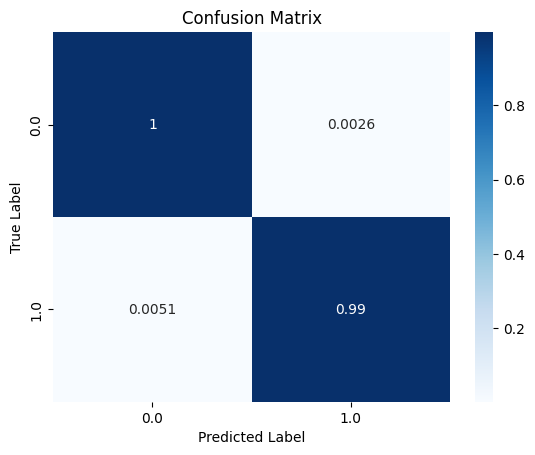

TEST ACCURACY: 0.997323291897287

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7600
           1       1.00      1.00      1.00     14442

    accuracy                           1.00     22042
   macro avg       1.00      1.00      1.00     22042
weighted avg       1.00      1.00      1.00     22042



In [84]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Convert list of lists into list of strings
new_texts = [' '.join(text) for text in df['Processed_Text']]

# Use the trained model to predict labels on the new texts
new_predictions = model_lr.predict(new_texts)

# Add the predicted labels to the new DataFrame
df['Predicted_Label'] = new_predictions

# Display the first few rows of the new DataFrame with predicted labels
print(df.head())

# Compare actual labels with predicted labels
actual_labels = df['Label']
predicted_labels = df['Predicted_Label']

# Confusion Matrix with normalized values
conf_matrix = confusion_matrix(test_labels, predictions, normalize='true')

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Calculate and print accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'TEST ACCURACY: {accuracy}\n')

# Print classification report
print(classification_report(actual_labels, predicted_labels))



**Using** **the** **RandomForest** **Classifier**

   Label                                               Text  \
0      1  Excision of limbal dermoids. We reviewed the c...   
1      1  Bell's palsy. A diagnosis of exclusion. In cas...   
2      1  Retained endobronchial foreign body removal fa...   
3      1  Recurrent buccal space abscesses: a complicati...   
4      1  Intracranial fibromatosis. Fibromatoses are un...   

                                      Processed_Text  \
0  [excision, limbal, dermoids, reviewed, clinica...   
1  [bell, palsy, diagnosis, exclusion, case, acut...   
2  [retained, endobronchial, foreign, body, remov...   
3  [recurrent, buccal, space, abscess, complicati...   
4  [intracranial, fibromatosis, fibromatoses, unc...   

                                    Sentiment_Scores  Predicted_Label  
0  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...              1.0  
1  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...              1.0  
2  [{'neg': 0.0, 'neu': 0.922, 'pos': 0.078, 'com...              1.

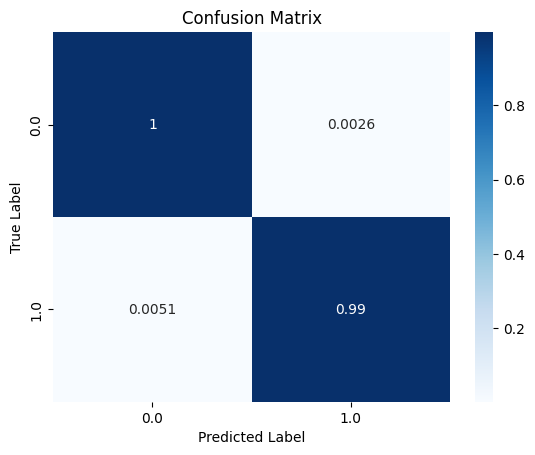

TEST ACCURACY: 0.9981399147082842

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7600
           1       1.00      1.00      1.00     14442

    accuracy                           1.00     22042
   macro avg       1.00      1.00      1.00     22042
weighted avg       1.00      1.00      1.00     22042



In [85]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Convert list of lists into list of strings
new_texts = [' '.join(text) for text in df['Processed_Text']]

# Use the trained model to predict labels on the new texts
new_predictions = model_rf.predict(new_texts)

# Add the predicted labels to the new DataFrame
df['Predicted_Label'] = new_predictions

# Display the first few rows of the new DataFrame with predicted labels
print(df.head())

# Compare actual labels with predicted labels
actual_labels = df['Label']
predicted_labels = df['Predicted_Label']


# Confusion Matrix with normalized values
conf_matrix = confusion_matrix(test_labels, predictions, normalize='true')

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'TEST ACCURACY: {accuracy}\n')

# Print classification report
print(classification_report(actual_labels, predicted_labels))



   Label                                               Text  \
0      1  Excision of limbal dermoids. We reviewed the c...   
1      1  Bell's palsy. A diagnosis of exclusion. In cas...   
2      1  Retained endobronchial foreign body removal fa...   
3      1  Recurrent buccal space abscesses: a complicati...   
4      1  Intracranial fibromatosis. Fibromatoses are un...   

                                      Processed_Text  \
0  [excision, limbal, dermoids, reviewed, clinica...   
1  [bell, palsy, diagnosis, exclusion, case, acut...   
2  [retained, endobronchial, foreign, body, remov...   
3  [recurrent, buccal, space, abscess, complicati...   
4  [intracranial, fibromatosis, fibromatoses, unc...   

                                    Sentiment_Scores  Predicted_Label  
0  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...              1.0  
1  [{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compoun...              1.0  
2  [{'neg': 0.0, 'neu': 0.922, 'pos': 0.078, 'com...              1.

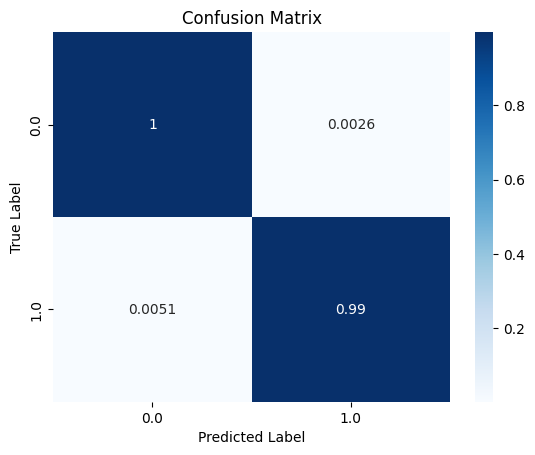

TEST ACCURACY: 0.9974593956991199

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7600
           1       1.00      1.00      1.00     14442

    accuracy                           1.00     22042
   macro avg       1.00      1.00      1.00     22042
weighted avg       1.00      1.00      1.00     22042



In [86]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Convert list of lists into list of strings
new_texts = [' '.join(text) for text in df['Processed_Text']]

# Use the trained model to predict labels on the new texts
new_predictions = ensemble_model.predict(new_texts)

# Add the predicted labels to the new DataFrame
df['Predicted_Label'] = new_predictions

# Display the first few rows of the new DataFrame with predicted labels
print(df.head())

# Compare actual labels with predicted labels
actual_labels = df['Label']
predicted_labels = df['Predicted_Label']


# Confusion Matrix with normalized values
conf_matrix = confusion_matrix(test_labels, predictions, normalize='true')

# Visualize Confusion Matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=['0.0', '1.0'], yticklabels=['0.0', '1.0'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'TEST ACCURACY: {accuracy}\n')

# Print classification report
print(classification_report(actual_labels, predicted_labels))



Just to make sure our model can predict on new unseen data we have used a new text containing medical text 1.0 is an indication that it is medical text while a prediction of 0 shows that it is non-medical text.

In [87]:
# Short text for prediction
new_text = "Regular exercise and a balanced diet are essential for maintaining good health and preventing chronic diseases. Make sure to incorporate physical activity into your daily routine and choose nutritious foods to support your overall well-being."
# new_text= "The stock market experienced a significant increase today as technology companies reported strong quarterly earnings. Investors are optimistic about the economic recovery and the growth potential of the technology sector."
# Preprocess the new text
processed_text, _ = preprocess_text(new_text)

# Convert the processed text to a string
processed_text_str = ' '.join(processed_text)

# Use the trained model to predict the label
predicted_label = model_lr.predict([processed_text_str])[0]

# Print the predicted label
print(f"Predicted Label: {predicted_label}")


Predicted Label: 1.0


##**RESULTS**

From our results it is clear that the model is performing well in classifying text as health related(1) or non-health related as can be seen from the accuracy scores on the Logistic Classifier and RandomForestClassifier with accuracy scores > 0.98.

In [88]:
import joblib

# Save the Random Forest model to a file
joblib.dump(model_rf, 'classification_model.pkl')


['classification_model.pkl']

In [89]:
loaded_model_rf = joblib.load('classification_model.pkl')
